# Metadata analysis of the MAST dataset

Reference: https://mastapp.site/

### Objectives:

* How many shots in the M9 campaign?
* Find label for each shot that tells if the shot is good or not? (how many shot left?)
* For a given shot, find labels for each diagnostic that tells if its a wrong one or not?
* A variable is called efit and refers to the EFIT++ reconstruction. See if there are information about the meaning of the variables.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import xarray as xr
import pathlib
import tqdm
import concurrent.futures
from functools import partial
import os
import psutil
import time


plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8
sns.set_palette('muted')

### 0. Visualization of the whole shots

In [4]:
URL = 'https://mastapp.site'

In [5]:
shots_df = pd.read_parquet(f'{URL}/parquet/level2/shots')
shots_df

,context,url,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,commissioner,facility,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11766.zarr,\nRELOAD 10232 PLASMA CONDITIONING SHOT FROM M4\n,"\nGOOD PLASMA, RAN FINE. SL JOINT ALARMS RATHE...",M5,None,Conventional,None,None,MAST,...,8.088068,8.478948,NaN,9286.269388,14370.632,NaN,NaN,NaN,NaN,-0.011828
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11767.zarr,\nREPEAT\n,\nOK BUT LOST VERTICAL CONTROL - FA2 JUST DIED...,M5,None,Conventional,None,None,MAST,...,7.707199,8.559942,NaN,7343.788162,11461.490,NaN,NaN,NaN,NaN,-0.007570
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11768.zarr,\nSELECT ALL 4 FAS AND LOAD EFC SETTINGS FROM ...,\nOK. GOT FA4 BUT NOT FA3\n,M5,None,Conventional,None,None,MAST,...,8.300782,8.580827,NaN,10585.928086,12660.081,NaN,NaN,NaN,NaN,-0.011107
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11769.zarr,"\nREPEAT, WITH TF RAISED TO 0.58.\n",\nSLIDING JOINT ALARMS A BIT LOWER. PLASMA OK.\n,M5,None,Conventional,None,None,MAST,...,8.112973,8.742647,NaN,8189.273726,12494.456,NaN,NaN,NaN,NaN,-0.008156
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11771.zarr,\nRELOADED 11769 AND SET UP PLASMA CURRENT FEE...,\nGOOD PLASMA F/B CONTROL. SLIDING JOINT ALARM...,M5,None,Conventional,None,None,MAST,...,7.978917,8.760519,NaN,8206.258460,12345.816,NaN,NaN,NaN,NaN,-0.008726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11276,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30467.zarr,\nRepeat with new neutron camera position.\ncH...,\nTwo times lower DD neutron rate than referen...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.029202,9.046394,NaN,49469.122469,52653.445,NaN,NaN,NaN,NaN,0.013202
11277,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30468.zarr,\nRepeat with new neutron camera position.\ncH...,\nGood beam.\nGood repeat.\n,M9,700 kA,Conventional,Lower Single Null,None,MAST,...,9.102411,9.107017,NaN,48516.962675,49382.133,NaN,NaN,NaN,NaN,0.012445
11278,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30469.zarr,\nRepeat with increased beam power (74 kV)\ncH...,\nGood shot. Modes present.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.988730,9.047923,NaN,47466.249616,49115.805,NaN,NaN,NaN,NaN,0.015299
11279,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30470.zarr,\nRepeat last using hydrogen in outboard and c...,\nNo HF gas.\n,M9,700 kA,Conventional,None,None,MAST,...,9.687049,10.055509,NaN,17290.432865,22310.516,NaN,NaN,NaN,NaN,0.015164


In [6]:
columns = shots_df.columns
print(f'Number of columns: {len(columns)}\n')
for col in columns:
    print(f"{col.ljust(25)}: {shots_df[col].dtype}")

Number of columns: 290

context                  : object
url                      : object
preshot_description      : object
postshot_description     : object
campaign                 : object
current_range            : object
divertor_config          : object
plasma_shape             : object
commissioner             : object
facility                 : object
type                     : object
title                    : object
shot_id                  : int64
uuid                     : object
endpoint_url             : object
timestamp                : datetime64[ns]
reference_shot           : float64
scenario                 : float64
heating                  : object
pellets                  : object
rmp_coil                 : object
cpf_p03249               : object
cpf_p04673               : object
cpf_p04674               : object
cpf_p04675               : object
cpf_p04676               : object
cpf_p04677               : object
cpf_p04678               : object
cpf_p04679     

In [7]:
print(shots_df.loc[0, 'cpf_zmag_efit'])

-0.01182766


### 1. M9 campaign selection

In [8]:
shots_df_m9 = pd.read_parquet(f'{URL}/parquet/level2/shots?filters=campaign$eq:M9')
shots_df_m9

,context,url,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,commissioner,facility,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28752.zarr,\nChange ZREF to +1cm.\n,\n280ms shot.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.654442,8.727527,None,44755.881482,67405.750,None,None,None,None,0.032862
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28647.zarr,\nRepeat after abort.\n,\nGood 400kA 330ms plasma shot.\n,M9,400 kA,Conventional,None,None,MAST,...,6.784744,9.231632,None,7209.400804,14854.986,None,None,None,None,-0.063345
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28750.zarr,\nChange zref to -1 cm\n,\n470ms shot. 400ms SS NBI. Sawteeth from 250m...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.083099,9.108404,None,44471.072260,72576.510,None,None,None,None,0.004665
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28631.zarr,"\nRepeat, with loop volts tweak and +-25kA P1P...",\nFirst plasma.\n,M9,400 kA,Conventional,None,None,MAST,...,5.389849,7.971025,None,1190.965664,3060.270,None,None,None,None,NaN
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28632.zarr,"\nRepeat, with -ve P1PS current limit 45kA. Tw...",\nGood plasma shot.\n,M9,400 kA,Conventional,None,None,MAST,...,8.597655,8.830988,None,5577.911845,24692.621,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30467.zarr,\nRepeat with new neutron camera position.\ncH...,\nTwo times lower DD neutron rate than referen...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.029202,9.046394,None,49469.122469,52653.445,None,None,None,None,0.013202
1097,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30468.zarr,\nRepeat with new neutron camera position.\ncH...,\nGood beam.\nGood repeat.\n,M9,700 kA,Conventional,Lower Single Null,None,MAST,...,9.102411,9.107017,None,48516.962675,49382.133,None,None,None,None,0.012445
1098,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30469.zarr,\nRepeat with increased beam power (74 kV)\ncH...,\nGood shot. Modes present.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.988730,9.047923,None,47466.249616,49115.805,None,None,None,None,0.015299
1099,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30470.zarr,\nRepeat last using hydrogen in outboard and c...,\nNo HF gas.\n,M9,700 kA,Conventional,None,None,MAST,...,9.687049,10.055509,None,17290.432865,22310.516,None,None,None,None,0.015164


In [9]:
print(f"Number of shots in M9 campaign: {len(shots_df_m9)}")

Number of shots in M9 campaign: 1101


Find the list of the M9 campaign shot_id

In [10]:
m9_shot_ids = shots_df_m9['shot_id'].tolist()

print(f"Number of shot IDs in M9 campaign: {len(m9_shot_ids)}")
print("M9 campaign shot_id:", m9_shot_ids[:5])

Number of shot IDs in M9 campaign: 1101
M9 campaign shot_id: [28752, 28647, 28750, 28631, 28632]


*Conclusion :*

*The number of shots during the M9 campaign is 1101.*

*That represents 8.89 % of the 11281 shots over all campaign.*


### 2. Find labels for each shot

Interesting columns:
* `cpf_abort`: interupted shot if 1
* `cpf_useful`: good for analysis if 1

In [11]:
# Sélectionner les colonnes spécifiques
abort_values = shots_df_m9['cpf_abort']
useful_values = shots_df_m9['cpf_useful']

# Afficher les 5 premières valeurs (exemple)
print("Valeurs de cpf_abort :\n", abort_values.describe())
print("\nValeurs de cpf_useful :\n", useful_values.describe())

Valeurs de cpf_abort :
 count    2.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: cpf_abort, dtype: float64

Valeurs de cpf_useful :
 count    755.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: cpf_useful, dtype: float64


In [12]:
good_shots = shots_df_m9.loc[(shots_df_m9['cpf_useful'] == 1) & (shots_df_m9['cpf_abort'] != 1)]
print(f"Number of good shots in M9 campaign: {len(good_shots)}")

Number of good shots in M9 campaign: 755


In [13]:
shots_df_m9['shot_label'] = (shots_df_m9['cpf_useful'] == 1).astype(int)
shots_df_m9[['shot_id','cpf_useful', 'cpf_abort', 'shot_label']]

,shot_id,cpf_useful,cpf_abort,shot_label
0,28752,1.0,NaN,1
1,28647,NaN,NaN,0
2,28750,1.0,NaN,1
3,28631,NaN,NaN,0
4,28632,NaN,NaN,0
...,...,...,...,...
1096,30467,1.0,NaN,1
1097,30468,1.0,NaN,1
1098,30469,1.0,NaN,1
1099,30470,NaN,NaN,0


Find the list of good shot_id and the list of bad shot_id.

In [14]:
good_shot_ids = shots_df_m9.loc[shots_df_m9['shot_label'] == 1, 'shot_id'].tolist()
bad_shot_ids = shots_df_m9.loc[shots_df_m9['shot_label'] == 0, 'shot_id'].tolist()

print(f"Number of good shot IDs: {len(good_shot_ids)}")
print("Good shot IDs:", good_shot_ids[:25])

print("\n")

print(f"Number of bad shot IDs: {len(bad_shot_ids)}")
print("Bad shot IDs:", bad_shot_ids[:5])

Number of good shot IDs: 755
Good shot IDs: [28752, 28750, 28655, 28656, 28657, 28744, 28751, 28747, 28748, 28749, 28755, 28757, 28758, 28763, 28801, 28764, 28765, 28766, 28767, 28768, 28769, 28770, 28771, 28772, 28773]


Number of bad shot IDs: 346
Bad shot IDs: [28647, 28631, 28632, 28652, 28653]


### 3. Find label for each disgnostics (M9 campaign + magnetics)

Finding a label per diagnostic is quite more difficult.

1. We will first try to see if there are labels in the existant dataset.
2. If not, we will implement unsuvervised technics to label the dataset.

In [15]:
# Shot_id number for example
sh_id = 28752
#sh_id = 15585
grp = 'magnetics'

In [16]:
data = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/{sh_id}.zarr",
    group=grp,
)
mag_var = data.data_vars
mag_var

Data variables:
    b_field_pol_probe_ccbv_field      (b_field_pol_probe_ccbv_channel, time) float64 741kB ...
    b_field_pol_probe_obr_field       (b_field_pol_probe_obr_channel, time) float64 334kB ...
    b_field_pol_probe_obv_field       (b_field_pol_probe_obv_channel, time) float64 334kB ...
    b_field_tor_probe_saddle_field    (b_field_tor_probe_saddle_field_channel, time_saddle) float64 2MB ...
    b_field_tor_probe_saddle_voltage  (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 2MB ...
    flux_loop_flux                    (flux_loop_channel, time) float64 278kB ...
    ip                                (time) float64 19kB ...

In [17]:
for var in mag_var:
    print(f"{var.ljust(35)}: {mag_var[var].attrs}")

b_field_pol_probe_ccbv_field       : {'description': 'Centre column Bv array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'label': 'CCBV01', 'name': 'b_field_pol_probe_ccbv_field', 'uda_name': 'AMB_CCBV01', 'units': 'T'}
b_field_pol_probe_obr_field        : {'description': 'Outer Br array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'label': 'OBR01', 'name': 'b_field_pol_probe_obr_field', 'uda_name': 'AMB_OBR01', 'units': 'T'}
b_field_pol_probe_obv_field        : {'description': 'Outer Bv array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'name': 'b_field_pol_probe_obv_field', 'units': 'T'}
b_field_tor_probe_saddle_field     : {'description': '', 'imas': 'magnetics.b_field_tor_probe[:].field.data', 'label': 'mT', 'name': 'b_field_tor_probe_saddle_field', 'uda_name': 'ASM_SAD/M01', 'units': 'T'}
b_field_tor_probe_saddle_voltage   : {'description': '', 'imas': 'magnetics.b_field_tor_probe[:].voltage.data', 'label': 'V', 'name': 'b_field_tor_probe_saddle_volt

In [18]:
data['ip']['time'].values

array([-0.10280025, -0.10260025, -0.10240025, ...,  0.35979975,
        0.35999975,  0.36019975], shape=(2316,))

In [19]:
signals_df = pd.read_parquet(f"{URL}/parquet/level2/signals?shot_id={sh_id}")
signals_df.head(5)

,context,shape,provenance,description,dimensions,quality,type,title,uuid,name,version,rank,url,endpoint_url,source,units,imas,shot_id
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[2316],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,e394530f-e608-5d90-93da-1851ec2cd082,ip,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,1ef217e3-12b0-5523-bfbf-f466db059e31,beta_normal,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,294c6905-fba4-5682-b8e0-047000ee5098,beta_pol,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,ed36483e-c8b5-56e1-9b92-67c9acd13e12,beta_tor,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,12feafef-7d0f-59a5-a5a7-226739e9008c,bphi_rmag,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752


In [20]:
signals_df.loc[4]

context         {'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...
shape                                                        [93]
provenance                                                   None
description                                                      
dimensions                                                 [time]
quality                                               Not Checked
type                                                 dcat:Dataset
title                                              Signal Dataset
uuid                         12feafef-7d0f-59a5-a5a7-226739e9008c
name                                                    bphi_rmag
version                                                         0
rank                                                            1
url                             s3://mast/level2/shots/28752.zarr
endpoint_url                           https://s3.echo.stfc.ac.uk
source                                                equilibrium
units     

In [21]:
signals_df.loc[signals_df['imas']=='magnetics'].head(5)

,context,shape,provenance,description,dimensions,quality,type,title,uuid,name,version,rank,url,endpoint_url,source,units,imas,shot_id
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[2316],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,e394530f-e608-5d90-93da-1851ec2cd082,ip,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
35,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[40, 2316]",None,,"[b_field_pol_probe_ccbv_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,586ebaa8-2901-5ccb-a88f-c91b7fa469af,b_field_pol_probe_ccbv_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
36,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[18, 2316]",None,,"[b_field_pol_probe_obr_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,4db8b61d-8d92-5f24-885e-114be1ad0775,b_field_pol_probe_obr_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
37,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[18, 2316]",None,,"[b_field_pol_probe_obv_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,63fce13c-2ed9-5378-aa29-03c5a457f4a1,b_field_pol_probe_obv_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
38,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[12, 23160]",None,,"[b_field_tor_probe_saddle_field_channel, time_...",Not Checked,dcat:Dataset,Signal Dataset,d9a3b4c0-06be-58fc-95b8-9891253e7d12,b_field_tor_probe_saddle_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752


In [22]:
shot_data = requests.get(f'https://mastapp.site/json/shots/{sh_id}').json()
for key, value in shot_data.items():
    if isinstance(value, list):
        print(f"{key.ljust(30)}: {len(value)} items")
    else:
        print(f"{key.ljust(30)}: {value}")

@context                      : {'dct': 'http://purl.org/dc/terms/', 'dqv': 'http://www.w3.org/ns/dqv#', 'url': 'schema:url', 'dcat': 'http://www.w3.org/ns/dcat#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'uuid': 'dct:identifier', 'title': 'dct:title', 'schema': 'https://schema.org', 'timestamp': 'dct:date', 'sdmx-measure': 'http://purl.org/linked-data/sdmx/2009/measure#'}
@type                         : dcat:Dataset
title                         : Shot Dataset
shot_id                       : 28752
uuid                          : 2bd7255e-9f9e-59ba-8968-6ece568e5755
url                           : s3://mast/level1/shots/28752.zarr
endpoint_url                  : https://s3.echo.stfc.ac.uk
timestamp                     : 2013-05-20T13:30:00
preshot_description           : 
Change ZREF to +1cm.

postshot_description          : 
280ms shot.

campaign                      : M9
reference_shot                : 28751
scenario                      : 3
heating                       : Ohmic
pellets

In [23]:
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)
print(f"Shot URL: {shot_url}")

Shot URL: https://s3.echo.stfc.ac.uk/mast/level1/shots/28752.zarr


*Conclusion :*

*Nothing here seems to be a good label for each diagnostic.*

*Update: After speaking with Samuel Jackson, there are in fact no label available for each diagnostics. But also, the shots' labels are kind of subjective and hand-crafted.*

### 4. EFIT++ information meaning

In [24]:
sh_id = 28752
sh_id = 15585
sh_id = 26320

grp = 'equilibrium'

In [25]:
data_eq = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/{sh_id}.zarr",
    group=grp,
)
eq_var = data_eq.data_vars
eq_var

Data variables:
    beta_normal          (time) float64 2kB ...
    beta_pol             (time) float64 2kB ...
    beta_tor             (time) float64 2kB ...
    bphi_rmag            (time) float64 2kB ...
    bvac_rmag            (time) float64 2kB ...
    da_rating            (time) float64 2kB ...
    elongation           (time) float64 2kB ...
    elongation_axis      (time) float64 2kB ...
    ip_rating            (time) float64 2kB ...
    j_tor                (time, z, major_radius) float64 9MB ...
    lcfs_r               (time, n_boundary_coords) float64 292kB ...
    lcfs_z               (time, n_boundary_coords) float64 292kB ...
    li                   (time) float64 2kB ...
    magnetic_axis_r      (time) float64 2kB ...
    magnetic_axis_z      (time) float64 2kB ...
    minor_radius         (time) float64 2kB ...
    psi                  (time, z, major_radius) float64 9MB ...
    q                    (time, profile_r) float64 131kB ...
    q100                 (time)

In [26]:
eq_coord = data_eq.coords
eq_coord

Coordinates:
  * major_radius       (major_radius) float64 520B 0.06 0.09 0.12 ... 1.95 1.98
  * n_boundary_coords  (n_boundary_coords) float32 580B 0.0 1.0 ... 143.0 144.0
  * n_x_points         (n_x_points) <U16 256B 'EFM_XPOINT1_R(C)' ... 'EFM_XPO...
  * profile_r          (profile_r) float32 260B 0.0 0.01562 ... 0.9844 1.0
  * time               (time) float64 2kB -0.4608 -0.4558 ... 0.7892 0.7942
  * z                  (z) float32 260B -2.0 -1.938 -1.875 ... 1.875 1.938 2.0

In [27]:
data_eq["psi"].attrs

{'description': '',
 'imas': 'equilibrium.time_slice[:].profiles_2d[:].psi',
 'label': 'psi(r,z)',
 'name': 'psi',
 'uda_name': 'EFM_PSI(R,Z)',
 'units': 'Wb / rad'}

In [28]:
data_eq["psi"].values[100]

array([[0.00038638, 0.00086685, 0.00153275, ..., 0.00330089, 0.00301806,
        0.00275437],
       [0.00046341, 0.0010403 , 0.00184113, ..., 0.00288405, 0.00259976,
        0.00233654],
       [0.0005515 , 0.0012376 , 0.00218985, ..., 0.00234794, 0.00207251,
        0.00181878],
       ...,
       [0.00058527, 0.00131555, 0.00233335, ..., 0.00662314, 0.00618463,
        0.00578194],
       [0.00049538, 0.00111266, 0.00197022, ..., 0.0072327 , 0.00677648,
        0.0063575 ],
       [0.00041507, 0.00093144, 0.00164746, ..., 0.00762706, 0.00717949,
        0.00676557]], shape=(65, 65))

### 5. Is `shot_id` crescent with the `timestamp` ?

In [29]:
sh_id = 28752
sh_id = 15585

In [30]:
shot_timestamp = requests.get(f'https://mastapp.site/json/shots/{sh_id}').json()["timestamp"]
shot_timestamp

'2006-06-08T12:57:00'

In [31]:
URL = 'https://mastapp.site'
shots_order = pd.read_parquet(f'{URL}/parquet/level2/shots') 

In [32]:
columns = shots_order.columns 
print(f'Number of columns: {len(columns)}\n')
for col in columns:
    print(f"{col.ljust(25)}: {shots_order[col].dtype}")

Number of columns: 290

context                  : object
url                      : object
preshot_description      : object
postshot_description     : object
campaign                 : object
current_range            : object
divertor_config          : object
plasma_shape             : object
commissioner             : object
facility                 : object
type                     : object
title                    : object
shot_id                  : int64
uuid                     : object
endpoint_url             : object
timestamp                : datetime64[ns]
reference_shot           : float64
scenario                 : float64
heating                  : object
pellets                  : object
rmp_coil                 : object
cpf_p03249               : object
cpf_p04673               : object
cpf_p04674               : object
cpf_p04675               : object
cpf_p04676               : object
cpf_p04677               : object
cpf_p04678               : object
cpf_p04679     

In [33]:
sorted_order = shots_order.sort_values("timestamp")

In [34]:
is_sorted = sorted_order["shot_id"].is_monotonic_increasing
print(f"Shot IDs are sorted by timestamp: {is_sorted}")

Shot IDs are sorted by timestamp: False


In [35]:
if not is_sorted:
    diffs = sorted_order["shot_id"].diff().fillna(1)
    non_increasing = sorted_order[diffs <= 0]
    print("Number of non-increasing shot_ids: ", len(non_increasing), "\n")
    print("Non-increasing shot_ids:")
    non_increasing_list = non_increasing[["timestamp", "shot_id"]].values.tolist()
    for ts, shot_id in non_increasing_list:
        print(f"Timestamp: {ts}, Shot ID: {shot_id}")

    file_path = "src/magnetics_diagnostic_analysis/results"
    suffix = ""
    path = pathlib.Path().absolute().parent.parent.parent / file_path / f"non_increasing_shot_id{suffix}.csv"
    non_increasing_list = pd.Series(non_increasing_list)
    non_increasing_list.to_csv(path, index=False)

Number of non-increasing shot_ids:  21 

Non-increasing shot_ids:
Timestamp: 2006-06-13 13:08:00, Shot ID: 15632
Timestamp: 2006-07-25 09:15:00, Shot ID: 15951
Timestamp: 2006-08-22 09:20:00, Shot ID: 16310
Timestamp: 2007-01-18 10:29:00, Shot ID: 16847
Timestamp: 2007-07-18 08:51:00, Shot ID: 18882
Timestamp: 2008-06-25 09:49:00, Shot ID: 19536
Timestamp: 2008-07-10 09:12:00, Shot ID: 19700
Timestamp: 2008-09-11 10:22:00, Shot ID: 20294
Timestamp: 2008-10-28 13:52:00, Shot ID: 20722
Timestamp: 2008-11-13 09:55:00, Shot ID: 20909
Timestamp: 2008-11-26 17:54:00, Shot ID: 20972
Timestamp: 2009-02-25 10:50:00, Shot ID: 21433
Timestamp: 2009-05-19 11:07:00, Shot ID: 22376
Timestamp: 2009-10-13 09:17:00, Shot ID: 23336
Timestamp: 2009-12-17 00:00:00, Shot ID: 23943
Timestamp: 2009-12-17 13:09:00, Shot ID: 23927
Timestamp: 2010-01-28 09:44:00, Shot ID: 24194
Timestamp: 2011-04-12 09:13:00, Shot ID: 25732
Timestamp: 2011-06-24 09:36:00, Shot ID: 26397
Timestamp: 2011-07-10 23:00:00, Shot ID: 

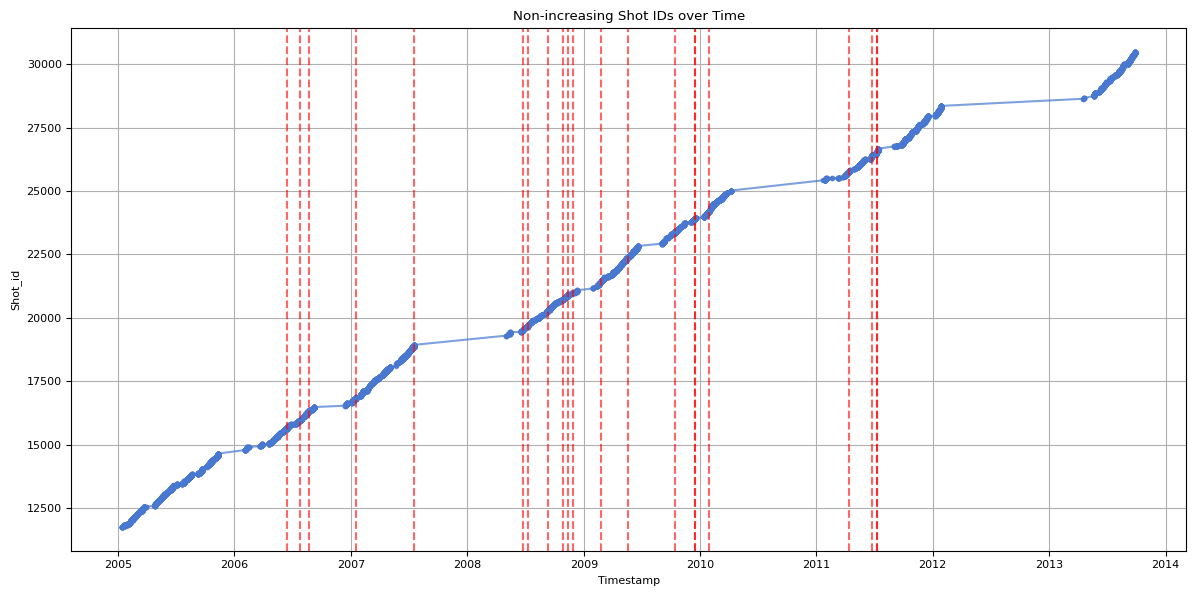

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(sorted_order["timestamp"], sorted_order["shot_id"], marker='.', linestyle='-', alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Shot_id")
plt.title("Non-increasing Shot IDs over Time")
plt.grid(True)

# Red vertical lines for non-increasing shot_ids
for ts in non_increasing["timestamp"]:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

*Conclusion :*

*The number of non-increasing shot_id through time are negligeable in comparison with the number of shots.*

### 6. Analysis of NaN apparition through time

In [37]:
def to_dask(shot: int, group: str, level: int = 2) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    level: Data level to retrieve (default is 2).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [38]:
def build_variable_vs_timestamp(
    shots: list[int],
    group: str,
    variable: str,
    verbose: bool = False
) -> xr.Dataset:
    """
    Concat data from a variable across multiple shots, aligned in absolute time based on the start timestamp of each shot.
    
    Parameters
    shots: list of int
        List of shot IDs to be processed.
    group: str
        Diagnostic group to which the variable belongs (e.g., “magnetics,” “summary,” etc.).
    variable: str
        Name of the variable to be retrieved.
    verbose: bool
        Displays messages for debugging or tracking.

    Returns
    xr.Dataset
        Dataset containing the variable concatenated across all shots, based on the actual timestamp.
    """
    all_data = []

    for shot_id in tqdm.tqdm(shots, desc="Loading shots", total=len(shots)):
        try:
            # Load data
            ds = to_dask(shot_id, group)
            if variable not in ds:
                if verbose:
                    print(f"Variable {variable} not in group {group} for shot {shot_id}")
                continue
            da = ds[variable]

            # Get timestamp of shot begining
            meta = requests.get(f"https://mastapp.site/json/shots/{shot_id}").json()
            t0 = pd.to_datetime(meta["timestamp"]).timestamp()  # UNIX timestamp (secondes))

            time_dim = next((dim for dim in da.dims if dim.startswith("time")), None)
            if time_dim is None:
                if verbose:
                    print(f"Aucune dimension temporelle pour {variable} dans shot {shot_id}")
                continue

            # Absolute time (secondes since UNIX) and then convert to datetime
            relative_time = ds[time_dim].values.astype(np.float64)  # secondes
            global_time = pd.to_datetime(t0 + relative_time, unit='s')  # Convert to datetime

            # New array with global time
            coords = {"time": global_time}
            dims = ("time",)
            if da.ndim == 2:
                chan_dim = [dim for dim in da.dims if dim != time_dim][0]
                coords[chan_dim] = ds[chan_dim]
                dims = ("time", chan_dim)

            da_new = xr.DataArray(
                da.values,
                dims=dims,
                coords=coords,
                attrs=da.attrs
            )

            all_data.append(da_new)

        except Exception as e:
            if verbose:
                print(f"Erreur avec le shot {shot_id}: {e}")
            continue

    result = xr.concat(all_data, dim="time").sortby("time")

    return xr.Dataset({variable: result})

In [ ]:
def check_variable_presence_by_channel(
    shots: list[int],
    group: str,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Check presence of all variables (and their channels) across shots in a group.

    Returns a DataFrame where:
    - Rows = variable::channel (or variable if 1D)
    - Columns = shot_id
    - Values = True (present and not NaN), None (only NaNs), False (missing)
    """
    var_presence: dict[str, dict[int, bool | None]] = {}
    seen_shots = []

    for shot_id in tqdm.tqdm(shots, desc="Checking variables", total=len(shots)):
        try:
            ds = to_dask(shot_id, group)
            shot_vars = set(ds.data_vars)

            for var in shot_vars:
                da = ds[var]
                other_dims = [dim for dim in da.dims if not dim.startswith("time")]

                # 1D variable (just time)
                if len(other_dims) == 0:
                    key = var
                    if key not in var_presence:
                        var_presence[key] = {s: False for s in seen_shots}

                    if np.issubdtype(da.dtype, np.floating):
                        all_nan = np.isnan(da.values).all()
                        var_presence[key][shot_id] = None if all_nan else True
                    else:
                        var_presence[key][shot_id] = True

                # 2D variable: split per channel
                elif len(other_dims) == 1:
                    chan_dim = other_dims[0]
                    if chan_dim not in ds.coords:
                        if verbose:
                            print(f"Warning: {chan_dim} not found in coords for {var} in shot {shot_id}")
                        continue

                    for chan in ds[chan_dim].values:
                        key = f"{var}::{chan}"
                        if key not in var_presence:
                            var_presence[key] = {s: False for s in seen_shots}

                        try:
                            slice_da = da.sel({chan_dim: chan})
                            if np.issubdtype(slice_da.dtype, np.floating):
                                all_nan = np.isnan(slice_da.values).all()
                                var_presence[key][shot_id] = None if all_nan else True
                            else:
                                var_presence[key][shot_id] = True
                        except Exception as e:
                            if verbose:
                                print(f"Error accessing {key} in shot {shot_id}: {e}")
                            var_presence[key][shot_id] = False
                else:
                    if verbose:
                        print(f"Skipping variable with unexpected dims: {var} -> {da.dims}")
                    continue

            # Mark missing variables/channels as False: case where there was a "continue"
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False

            seen_shots.append(shot_id)

        except Exception as e:
            if verbose:
                print(f"Error processing shot {shot_id}: {e}")
            # Mark all known vars as False
            for key in var_presence:
                var_presence[key][shot_id] = False

    df = pd.DataFrame(var_presence).T
    return df

In [ ]:
def check_variable_presence_by_channel_vectorized(
    shots: list[int],
    group: str,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Check presence of all variables (and their channels) across shots in a group.
    Vectorized version for better performance.
    
    Returns a DataFrame where:
    - Rows = variable::channel (or variable if 1D)
    - Columns = shot_id
    - Values = True (present and not NaN), None (only NaNs), False (missing)
    """
    var_presence = {}
    seen_shots = []

    for shot_id in tqdm.tqdm(shots, desc="Checking variables", total=len(shots)):
        try:
            ds = to_dask(shot_id, group)
            shot_vars = set(ds.data_vars)

            for var in shot_vars:
                da = ds[var]
                time_dims = [dim for dim in da.dims if 'time' in dim.lower()]
                
                if not time_dims:
                    if verbose:
                        print(f"Skipping {var} with no time dimension: {da.dims}")
                    continue
                
                time_dim = time_dims[0]  # First dimension containing 'time'
                other_dims = [dim for dim in da.dims if dim != time_dim]

                # 1. Variable 1D (just time)
                if not other_dims:
                    key = var
                    if key not in var_presence:
                        var_presence[key] = {s: False for s in seen_shots}
                    
                    try:
                        if np.issubdtype(da.dtype, np.floating):
                            has_valid = da.notnull().any().compute()
                            var_presence[key][shot_id] = True if has_valid else None
                        else:
                            var_presence[key][shot_id] = True
                    except Exception as e:
                        if verbose:
                            print(f"Error processing {var} in shot {shot_id}: {e}")
                        var_presence[key][shot_id] = False

                # 2. Variable 2D: split per channel
                else:
                    for dim in other_dims:
                        if dim not in ds.coords:
                            if verbose:
                                print(f"Warning: {dim} not found for {var} in shot {shot_id}")
                            continue
                        
                        try:
                            if np.issubdtype(da.dtype, np.floating):
                                channel_has_data = da.notnull().any(dim=time_dim)
                            else:
                                channel_has_data = xr.ones_like(ds[dim], dtype=bool)
                            
                            channel_results = channel_has_data.compute()
                            
                            for coord_val in ds[dim].values:
                                key = f"{var}::{coord_val}"
                                if key not in var_presence:
                                    var_presence[key] = {s: False for s in seen_shots}
                                
                                try:
                                    chan_valid = channel_results.sel({dim: coord_val}).item()
                                    var_presence[key][shot_id] = True if chan_valid else None
                                except Exception as e:
                                    if verbose:
                                        print(f"Error accessing {coord_val} in {var}: {e}")
                                    var_presence[key][shot_id] = False
                        
                        except Exception as e:
                            if verbose:
                                print(f"Error processing {var} in shot {shot_id}: {e}")
                            for coord_val in ds[dim].values:
                                key = f"{var}::{coord_val}"
                                if key not in var_presence:
                                    var_presence[key] = {s: False for s in seen_shots}
                                var_presence[key][shot_id] = False

            # Missing variables/channels: case where there was a "continue"
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False
            
            seen_shots.append(shot_id)
            
        except Exception as e:
            if verbose:
                print(f"Error processing shot {shot_id}: {e}")
            for key in var_presence:
                var_presence[key][shot_id] = False

    return pd.DataFrame(var_presence).T

In [ ]:
def retry_to_dask(shot_id, group, retries=3, delay=5):
    """
    Retry loading a shot's data as a Dask Dataset with exponential backoff.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    retries: Number of retry attempts (default is 3).
    delay: Delay in seconds between retries (default is 5).
    """
    for attempt in range(retries):
        try:
            return to_dask(shot_id, group)
        except Exception as e:
            if attempt < retries - 1:
                print(f"Retrying connection to {shot_id} in group {group} (attempt {attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                raise e



def process_shot(shot_id, group, verbose=False):
    """
    Process a single shot, returning a dictionary of results.
    """
    shot_result = {}
    try:
        ds = retry_to_dask(shot_id, group)
        shot_vars = set(ds.data_vars)

        for var in shot_vars:
            da = ds[var]
            time_dims = [dim for dim in da.dims if 'time' in dim.lower()]
            
            if not time_dims:
                if verbose:
                    print(f"Skipping {var} with no time dimension: {da.dims}")
                continue
            
            time_dim = time_dims[0]
            other_dims = [dim for dim in da.dims if dim != time_dim]

            # 1. Variable 1D
            if not other_dims:
                key = var
                try:
                    if np.issubdtype(da.dtype, np.floating):
                        has_valid = da.notnull().any().compute()
                        shot_result[key] = True if has_valid else None
                    else:
                        shot_result[key] = True
                except Exception as e:
                    if verbose:
                        print(f"Error processing {var} in shot {shot_id}: {e}")
                    shot_result[key] = False

            # 2. Variable 2D
            else:
                for dim in other_dims:
                    if dim not in ds.coords:
                        if verbose:
                            print(f"Warning: {dim} not found for {var} in shot {shot_id}")
                        continue
                    
                    try:
                        if np.issubdtype(da.dtype, np.floating):
                            channel_has_data = da.notnull().any(dim=time_dim)
                        else:
                            channel_has_data = xr.ones_like(ds[dim], dtype=bool)
                        
                        channel_results = channel_has_data.compute()
                        
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            try:
                                chan_valid = channel_results.sel({dim: coord_val}).item()
                                shot_result[key] = True if chan_valid else None
                            except Exception as e:
                                if verbose:
                                    print(f"Error accessing {coord_val} in {var}: {e}")
                                shot_result[key] = False
                    
                    except Exception as e:
                        if verbose:
                            print(f"Error processing {var} in shot {shot_id}: {e}")
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            shot_result[key] = False

    except Exception as e:
        if verbose:
            print(f"Error processing shot {shot_id}: {e}")
        shot_result = {}

    return shot_id, shot_result



def get_optimal_workers(task_type="cpu"):
    """
    Returns the optimal number of workers based on the task type.
    """
    cpu_logical = os.cpu_count()
    
    if task_type == "cpu":
        try:
            return psutil.cpu_count(logical=False)
        except:
            return max(1, cpu_logical // 2)  # Default to half of logical cores
    else:
        return max(1, cpu_logical - 1) # Default to one less than logical cores
    


def check_variable_presence_parallel(
    shots: list[int],
    group: str,
    verbose: bool = False,
    max_workers: int = None
) -> pd.DataFrame:
    
    """
    Parallelized version with ThreadPoolExecutor.
    Check presence of all variables (and their channels) across shots in a group.

    Parameters
    shots: list of int
        List of shot IDs to be processed.
    group: str
        Diagnostic group to which the variable belongs (e.g., “magnetics,” “summary,” etc.).
    verbose: bool
        Displays messages for debugging or tracking.
    max_workers: int, optional
        Maximum number of workers to use for parallel processing. If None, uses an optimal value based on get_optimal_worker.
    """
    if max_workers is None:
        max_workers = get_optimal_workers()
    print(f"Use of {max_workers} workers (type: cpu)")
    
    var_presence = {}
    seen_shots = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for shot_id in shots:
            futures.append(executor.submit(partial(process_shot, group=group, verbose=verbose), shot_id))
        
        for future in tqdm.tqdm(
            concurrent.futures.as_completed(futures),
            total=len(shots),
            desc="Checking variables (parallel)"
        ):
            shot_id, shot_result = future.result()
            seen_shots.append(shot_id)
            
            for key, present in shot_result.items():
                if key not in var_presence:
                    var_presence[key] = {s: False for s in seen_shots}
                var_presence[key][shot_id] = present
            
            # Marquer les variables manquantes pour ce shot
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False

    df = pd.DataFrame(var_presence).T
    df = df.reindex(sorted(df.columns), axis=1)
    
    return df

In [42]:
URL = 'https://mastapp.site'
shots_disappearance = pd.read_parquet(f'{URL}/parquet/level2/shots')
sorted_disappearance = shots_disappearance.sort_values("timestamp")
shots = sorted_disappearance['shot_id'].tolist()
print("Number of shots: ", len(shots))

Number of shots:  11281


In [43]:
group = 'magnetics'
variable = 'ip'

In [44]:
variable_vs_timestamp = build_variable_vs_timestamp(
    shots=shots[:100], 
    group=group, 
    variable=variable, 
    verbose=True)

Loading shots: 100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


In [45]:
variable_presence = check_variable_presence_by_channel(
    shots=shots[:100], 
    group=group, 
    verbose=True)

Checking variables: 100%|██████████| 100/100 [21:26<00:00, 12.87s/it]


In [46]:
variable_presence_vectorized = check_variable_presence_by_channel_vectorized(
    shots=shots[:100], 
    group=group, 
    verbose=True)

Checking variables: 100%|██████████| 100/100 [05:37<00:00,  3.37s/it]


In [47]:
variable_presence_parallel= check_variable_presence_parallel(
    shots=shots[:100], 
    group=group, 
    verbose=True,
    max_workers=None)

Use of 6 workers (type: cpu)


Checking variables (parallel): 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


#### Analysing the results

In [48]:
variable_vs_timestamp

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 238745)
Coordinates:
  * time     (time) datetime64[ns] 2MB 2005-01-13T12:01:59.932800055 ... 2005...
Data variables:
    ip       (time) float64 2MB 5.039e+03 5.184e+03 ... 3.168e+03 3.168e+03

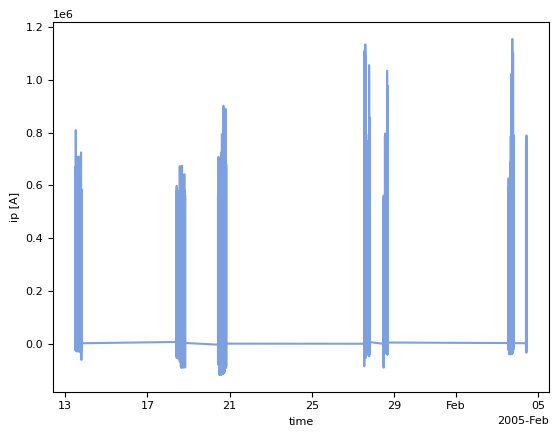

In [49]:
variable_vs_timestamp[variable].plot(x="time", alpha=0.7)

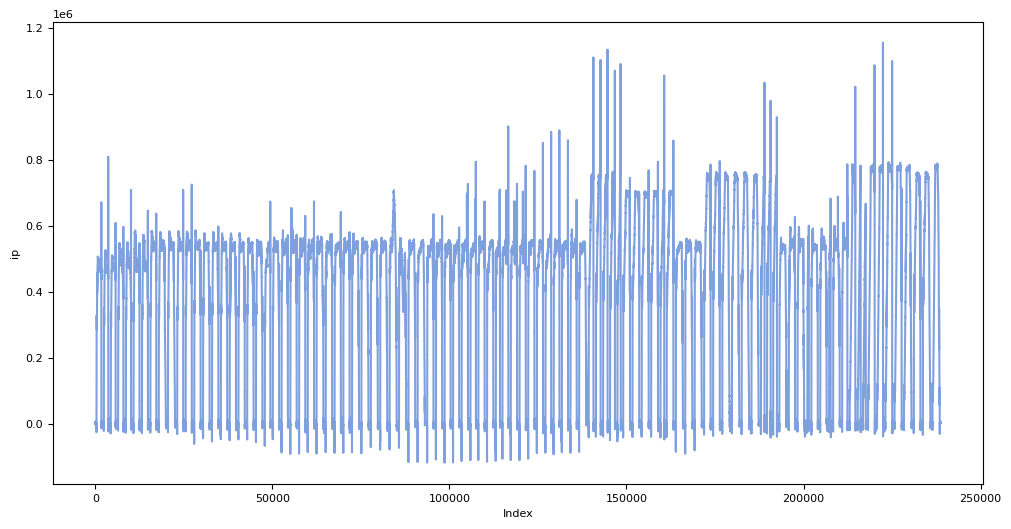

In [50]:
var_plot = variable_vs_timestamp[variable]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(var_plot.values, alpha=0.7)
ax.set_xlabel("Index")
ax.set_ylabel(variable)
plt.show()

In [51]:
variable_presence

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776,...,11899,11901,11902,11903,11905,11906,11908,11911,11912,11913
b_field_pol_probe_obr_field::AMB_OBR01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR02,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_pol_probe_obr_field::AMB_OBR03,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR04,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR05,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_field::ASM_SAD/M11,False,False,None,None,None,None,None,None,None,False,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_saddle_field::ASM_SAD/M12,False,False,None,None,None,None,None,None,None,False,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_cc_field::XMC_CC/MT/201,False,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_cc_field::XMC_CC/MT/206,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [52]:
variable_presence_vectorized

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776,...,11899,11901,11902,11903,11905,11906,11908,11911,11912,11913
b_field_pol_probe_obr_field::AMB_OBR01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR02,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_pol_probe_obr_field::AMB_OBR03,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR04,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR05,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_field::ASM_SAD/M11,False,False,None,None,None,None,None,None,None,False,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_saddle_field::ASM_SAD/M12,False,False,None,None,None,None,None,None,None,False,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_cc_field::XMC_CC/MT/201,False,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_cc_field::XMC_CC/MT/206,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [53]:
variable_presence_parallel

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776,...,11899,11901,11902,11903,11905,11906,11908,11911,11912,11913
b_field_pol_probe_obr_field::AMB_OBR01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR02,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_pol_probe_obr_field::AMB_OBR03,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR04,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR05,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_field::ASM_SAD/M11,False,False,None,None,None,None,None,None,None,False,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_saddle_field::ASM_SAD/M12,False,False,None,None,None,None,None,None,None,False,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_cc_field::XMC_CC/MT/201,False,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_tor_probe_cc_field::XMC_CC/MT/206,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [54]:
def are_identical(variable_presence1, variable_presence2):
    """
    Check if two DataFrames are identical.
    """
    are_identical = variable_presence1.equals(variable_presence2)
    print(f"Identical dataframes ?  {are_identical}")

    if not are_identical:
        # Find differences
        diff_mask = variable_presence1 != variable_presence2
        diff_count = diff_mask.sum().sum()

        print(f"Total number of differences: {diff_count}")

        # If diff, percentage:
        total_cells = variable_presence1.size
        diff_percentage = (diff_count / total_cells) * 100
        print(f"D {diff_percentage:.2f}%")

In [55]:
print("Comparing variable_presence with variable_presence_vectorized:")
are_identical(variable_presence, variable_presence_vectorized)
print("\n===============================================\n")
print("Comparing variable_presence with variable_presence_parallel:")
are_identical(variable_presence, variable_presence_parallel)

Comparing variable_presence with variable_presence_vectorized:
Identical dataframes ?  True


Comparing variable_presence with variable_presence_parallel:
Identical dataframes ?  True


#### All shot scraping

Prediction of running time:

* For 100 shots on 'magnetics' group, the parallel function took 0:53 minutes.
* Thus (for 11281 shots), we expect a run time of 1 hour and 39 minutes.

In [56]:
variable_presence_all = check_variable_presence_parallel(
    shots=shots, 
    group=group, 
    verbose=True,
    max_workers=None)

Use of 6 workers (type: cpu)


Checking variables (parallel):  53%|█████▎    | 5937/11281 [1:14:37<16:57,  5.25it/s]  

Error processing shot 21648: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing shot 21641: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing shot 21646: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing shot 21642: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21647: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo 

Checking variables (parallel):  53%|█████▎    | 5959/11281 [1:14:37<04:49, 18.37it/s]

Error processing flux_loop_flux in shot 21640: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 21691: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21695: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21696: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21682: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 21690: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21703: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21697: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21698: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error proc

Checking variables (parallel):  53%|█████▎    | 5995/11281 [1:14:37<01:49, 48.48it/s]

Error processing shot 21728: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 21731: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21727: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21730: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21732: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21729: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 21735: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21739: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21738: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21740:

Checking variables (parallel):  53%|█████▎    | 6031/11281 [1:14:37<01:03, 82.67it/s]

Error processing shot 21782: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 21778: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21783: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21779: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21780: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21781: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 21785: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21788: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21787: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21786:

Checking variables (parallel):  54%|█████▍    | 6082/11281 [1:14:38<00:39, 132.62it/s]

Error processing shot 21832: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 21837: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21833: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21838: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21835: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21836: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 21844: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21845: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21846: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21847:

Checking variables (parallel):  54%|█████▍    | 6121/11281 [1:14:38<00:34, 149.72it/s]

Error processing shot 21876: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21889: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21890: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21888: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21886: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21887: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21884: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21892: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21897: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21891:

Checking variables (parallel):  55%|█████▍    | 6160/11281 [1:14:38<00:32, 156.63it/s]

Error processing shot 21923: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 21920: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21922: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21921: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21924: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21925: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 21930: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21931: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21926: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21928:

Checking variables (parallel):  55%|█████▍    | 6178/11281 [1:14:38<00:31, 162.21it/s]

Error processing shot 21975: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 21974: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21972: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21971: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21970: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21973: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 21977: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21981: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21980: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 21979:

Checking variables (parallel):  55%|█████▌    | 6226/11281 [1:14:38<00:29, 169.19it/s]

Error processing shot 22017: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22012: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22016: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22018: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22015: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22014: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22022: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22027:

Checking variables (parallel):  56%|█████▌    | 6268/11281 [1:14:39<00:28, 176.55it/s]

Error processing shot 22059: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22060: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22061: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22058: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22057: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22056: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22070: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22066: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22062: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22064:

Checking variables (parallel):  56%|█████▌    | 6310/11281 [1:14:39<00:29, 170.69it/s]

Error processing shot 22102: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22105: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22112: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22116: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22117: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22118: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22114: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22115: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22113: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22119:

Checking variables (parallel):  56%|█████▋    | 6352/11281 [1:14:39<00:27, 176.41it/s]

Error processing shot 22153: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22151: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22152: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22149: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22148: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22146: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22154: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22157: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22159: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22156:

Checking variables (parallel):  56%|█████▋    | 6370/11281 [1:14:39<00:27, 175.98it/s]

Error processing shot 22212: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22211: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22209: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22210: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22206: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22200: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22217: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22215: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22219: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22214:

Checking variables (parallel):  57%|█████▋    | 6405/11281 [1:14:40<00:31, 153.59it/s]

Error processing shot 22244: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22245: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22243: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22238: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22242: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22241: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22248: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22246: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22249: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22250:

Checking variables (parallel):  57%|█████▋    | 6421/11281 [1:14:40<00:35, 137.01it/s]

Error processing shot 22272: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22271: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22266: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22267: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22270: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22268: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22278: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22277: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22274: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22275:

Checking variables (parallel):  57%|█████▋    | 6449/11281 [1:14:40<00:41, 116.00it/s]

Error processing shot 22294: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22287: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22301: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22300: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22296: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22297: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22295: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22298: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22307: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22305:

Checking variables (parallel):  57%|█████▋    | 6477/11281 [1:14:40<00:37, 126.46it/s]

Error processing shot 22321: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22322: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22323: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22317: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22315: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22316: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22324: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22326: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22327: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22329:

Checking variables (parallel):  58%|█████▊    | 6504/11281 [1:14:40<00:38, 123.62it/s]

Error processing shot 22402: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22403: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22399: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22397: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22398: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22401: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22408: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22415: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22416: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22414:

Checking variables (parallel):  58%|█████▊    | 6529/11281 [1:14:41<00:43, 108.88it/s]

Error processing shot 22434: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22431: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22435: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22433: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22432: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22430: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22437: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22438: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22441:

Checking variables (parallel):  58%|█████▊    | 6541/11281 [1:14:41<00:46, 101.34it/s]

Error processing shot 22457: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22455: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22456: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22453: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22454: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22459: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22460: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22464: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22469: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22461:

Checking variables (parallel):  58%|█████▊    | 6562/11281 [1:14:41<00:58, 80.49it/s] 

Error processing shot 22484: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22486: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22485: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22483: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22488: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22487: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22493: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22491: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22490: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22494:

Checking variables (parallel):  58%|█████▊    | 6585/11281 [1:14:41<00:55, 84.90it/s]

Error processing shot 22513: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22517: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22511: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22512: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22510: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22514: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22523: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22524: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22521: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22518:

Checking variables (parallel):  59%|█████▊    | 6608/11281 [1:14:42<01:05, 71.42it/s]

Error processing shot 22534: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22533: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22531: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22532: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22535: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22536: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22546: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22543: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22542: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22538:

Checking variables (parallel):  59%|█████▊    | 6617/11281 [1:14:42<01:22, 56.60it/s]

Error processing shot 22547: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22554: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22557: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22553: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22556: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22555: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]


Checking variables (parallel):  59%|█████▊    | 6624/11281 [1:14:42<01:20, 58.18it/s]

Error processing shot 22559: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22561: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22560: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22558: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22563: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22562: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22564: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22565: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22571: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22566:

Checking variables (parallel):  59%|█████▉    | 6631/11281 [1:14:42<01:28, 52.79it/s]

Error processing shot 22574: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22575: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22577: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22572: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22573: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22576: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]



Checking variables (parallel):  59%|█████▉    | 6638/11281 [1:14:43<02:06, 36.70it/s]

Error processing shot 22579: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22582: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22580: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22583: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22581: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22578: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]



Checking variables (parallel):  59%|█████▉    | 6654/11281 [1:14:43<01:42, 44.95it/s]

Error processing shot 22585: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22589: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22587: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22588: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22590: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22584: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22597: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22591: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22592: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22595:

Checking variables (parallel):  59%|█████▉    | 6668/11281 [1:14:43<01:41, 45.26it/s]

Error processing shot 22610: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22606: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22608: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22609: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22611: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22607: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22616: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22617: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22614: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22615:

Checking variables (parallel):  59%|█████▉    | 6674/11281 [1:14:43<01:35, 48.14it/s]

Error processing shot 22622: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22623: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22621: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22618: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22620: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22619: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22629: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22630: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22631: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22626:

Checking variables (parallel):  59%|█████▉    | 6698/11281 [1:14:44<01:10, 64.82it/s]

Error processing shot 22642: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22641: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22640: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22638: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22646: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22639: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22650: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22652: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22649: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22651:

Checking variables (parallel):  60%|█████▉    | 6717/11281 [1:14:44<01:09, 65.96it/s]

Error processing shot 22660: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22666: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22664: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22659: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22665: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22662: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22667: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22675: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22676: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22672:

Checking variables (parallel):  60%|█████▉    | 6728/11281 [1:14:44<01:07, 67.57it/s]

Error processing shot 22691: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22692: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22688: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22690: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22689: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22693: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22697: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22696: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22694: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22699:

Checking variables (parallel):  60%|█████▉    | 6743/11281 [1:14:44<01:19, 56.86it/s]

Error processing shot 22698: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22709: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22707: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22705: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22708: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22706: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22702: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]


Checking variables (parallel):  60%|█████▉    | 6750/11281 [1:14:45<01:29, 50.42it/s]

Error processing shot 22712: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 22715: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22710: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22714: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 22713: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 22711: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]


Checking variables (parallel):  82%|████████▏ | 9211/11281 [2:30:49<1:37:54,  2.84s/it]

Error processing b_field_pol_probe_cc_field in shot 27172: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)Error processing b_field_tor_probe_omaha_voltage in shot 27175: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing b_field_tor_probe_omaha_voltage in shot 27177: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)

Error processing b_field_pol_probe_obv_field in shot 27174: Cannot connect to host s3.echo.stfc.ac.uk:443 ss

Checking variables (parallel):  82%|████████▏ | 9217/11281 [2:30:50<29:37,  1.16it/s]  

Error processing b_field_tor_probe_saddle_field in shot 27174: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing b_field_pol_probe_cc_field in shot 27173: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27182: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_cc_field in shot 27172: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_cc_field in shot 27177: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_cc_field in shot 27175: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27183: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_saddle_field in shot 27173: Cannot connect to host s3.e

Checking variables (parallel):  82%|████████▏ | 9251/11281 [2:30:50<03:13, 10.47it/s]

Error processing shot 27192: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27193: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27194: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_cc_field in shot 27177: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_cc_field in shot 27175: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing flux_loop_flux in shot 27173: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27196: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27195: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27197: Cannot connect to host s3.ech

Checking variables (parallel):  83%|████████▎ | 9311/11281 [2:30:50<00:54, 36.27it/s]

Error processing shot 27257: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27256: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27254: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27255: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27258: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27253: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27269: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27268: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27260: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27267:

Checking variables (parallel):  83%|████████▎ | 9369/11281 [2:30:50<00:25, 75.54it/s]

Error processing shot 27324: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27325: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27328: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27326: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27329: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27327: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27333: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27332: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27334: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27331:

Checking variables (parallel):  84%|████████▎ | 9435/11281 [2:30:50<00:13, 134.12it/s]

Error processing shot 27405: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27401: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27402: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27407: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27408: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27411: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27412: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27409: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27410: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27414:

Checking variables (parallel):  84%|████████▍ | 9513/11281 [2:30:51<00:08, 215.35it/s]

Error processing shot 27492: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27493: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27490: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27491: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27489: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27488: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27499: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27494: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27497: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27495:

Checking variables (parallel):  85%|████████▍ | 9583/11281 [2:30:51<00:06, 267.50it/s]

Error processing shot 27578: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27577: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27576: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27575: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27573: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27574: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27580: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27579: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27585: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27581:

Checking variables (parallel):  86%|████████▌ | 9651/11281 [2:30:51<00:05, 296.41it/s]

Error processing shot 27662: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27663: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27661: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27660: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27658: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27659: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27668: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27664: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27666: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27667:

Checking variables (parallel):  87%|████████▋ | 9771/11281 [2:30:51<00:04, 352.75it/s]

Error processing shot 27760: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27757: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27759: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27756: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27755: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27754: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27766: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27765: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27767: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27763:

Checking variables (parallel):  87%|████████▋ | 9808/11281 [2:30:51<00:04, 353.95it/s]

Error processing shot 27873: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27868: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27872: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27874: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27871: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27870: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27879: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27880: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27875: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27878:

Checking variables (parallel):  88%|████████▊ | 9879/11281 [2:30:52<00:04, 308.56it/s]

Error processing shot 27946: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 27938: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27945: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27943: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27944: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27941: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 27953: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27951: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27950: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 27952:

Checking variables (parallel):  88%|████████▊ | 9911/11281 [2:30:52<00:04, 286.29it/s]

Error processing shot 28025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28035: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28032: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28034: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28033: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28031: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28041: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28042: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28040: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28043:

Checking variables (parallel):  88%|████████▊ | 9967/11281 [2:30:52<00:05, 235.13it/s]

Error processing shot 28072: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28073: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28070: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28071: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28074: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28075: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28079: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28077: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28078: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28076:

Checking variables (parallel):  89%|████████▉ | 10016/11281 [2:30:52<00:06, 199.39it/s]

Error processing shot 28130: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28128: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28129: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28127: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28132: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28131: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28136: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28135: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28140: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28134:

Checking variables (parallel):  89%|████████▉ | 10058/11281 [2:30:53<00:06, 200.82it/s]

Error processing shot 28164: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28165: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28173: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28176: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28170: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28169: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28168: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28167: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28182: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28178:

Checking variables (parallel):  90%|████████▉ | 10102/11281 [2:30:53<00:06, 186.61it/s]

Error processing shot 28229: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28225: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28228: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28227: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28224: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28226: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28231: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28232: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28235: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28230:

Checking variables (parallel):  90%|████████▉ | 10121/11281 [2:30:53<00:06, 177.45it/s]

Error processing shot 28266: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28267: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28269: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28272: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28268: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28270: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28277: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28276: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28278: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28274:

Checking variables (parallel):  90%|█████████ | 10164/11281 [2:30:53<00:05, 191.14it/s]

Error processing shot 28311: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28309: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28313: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28308: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28310: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28314: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28316: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28315: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28317: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28319:

Checking variables (parallel):  91%|█████████ | 10210/11281 [2:30:53<00:05, 189.60it/s]

Error processing shot 28647: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28631: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28652: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28653: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28352: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28632: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28745: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28744: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28655: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28656:

Checking variables (parallel):  91%|█████████ | 10270/11281 [2:30:54<00:04, 227.97it/s]

Error processing shot 28803: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28801: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28802: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28798: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28791: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28796: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28811: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28810: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28814: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28808:

Checking variables (parallel):  91%|█████████▏| 10294/11281 [2:30:54<00:04, 230.46it/s]

Error processing shot 28863: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 28864: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28858: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28861: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28857: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28860: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 28898: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28868: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28897: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 28867:

Checking variables (parallel):  92%|█████████▏| 10327/11281 [2:30:54<00:03, 254.17it/s]

Error processing shot 28999: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing shot 29002: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29000: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29001: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29003: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29004: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing shot 29011: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29008: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29010: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing shot 29009:

Checking variables (parallel): 100%|██████████| 11281/11281 [3:19:40<00:00,  1.06s/it]  


In [57]:
variable_presence_all

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776,...,30462,30463,30464,30465,30466,30467,30468,30469,30470,30471
b_field_pol_probe_obr_field::AMB_OBR01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR02,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
b_field_pol_probe_obr_field::AMB_OBR03,True,True,True,True,True,True,True,True,True,True,...,None,None,None,None,None,None,None,None,None,None
b_field_pol_probe_obr_field::AMB_OBR04,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
b_field_pol_probe_obr_field::AMB_OBR05,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M08,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M09,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M10,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M11,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
file_path = "src/magnetics_diagnostic_analysis/results"
path = pathlib.Path().absolute().parent.parent.parent / file_path / f"variable_presence_all shots_2.csv"
variable_presence_all.to_csv(path, index=False)

C:\Users\brussel\AppData\Local\Temp\ipykernel_1312\1971897953.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = variable_presence_all.fillna(False)


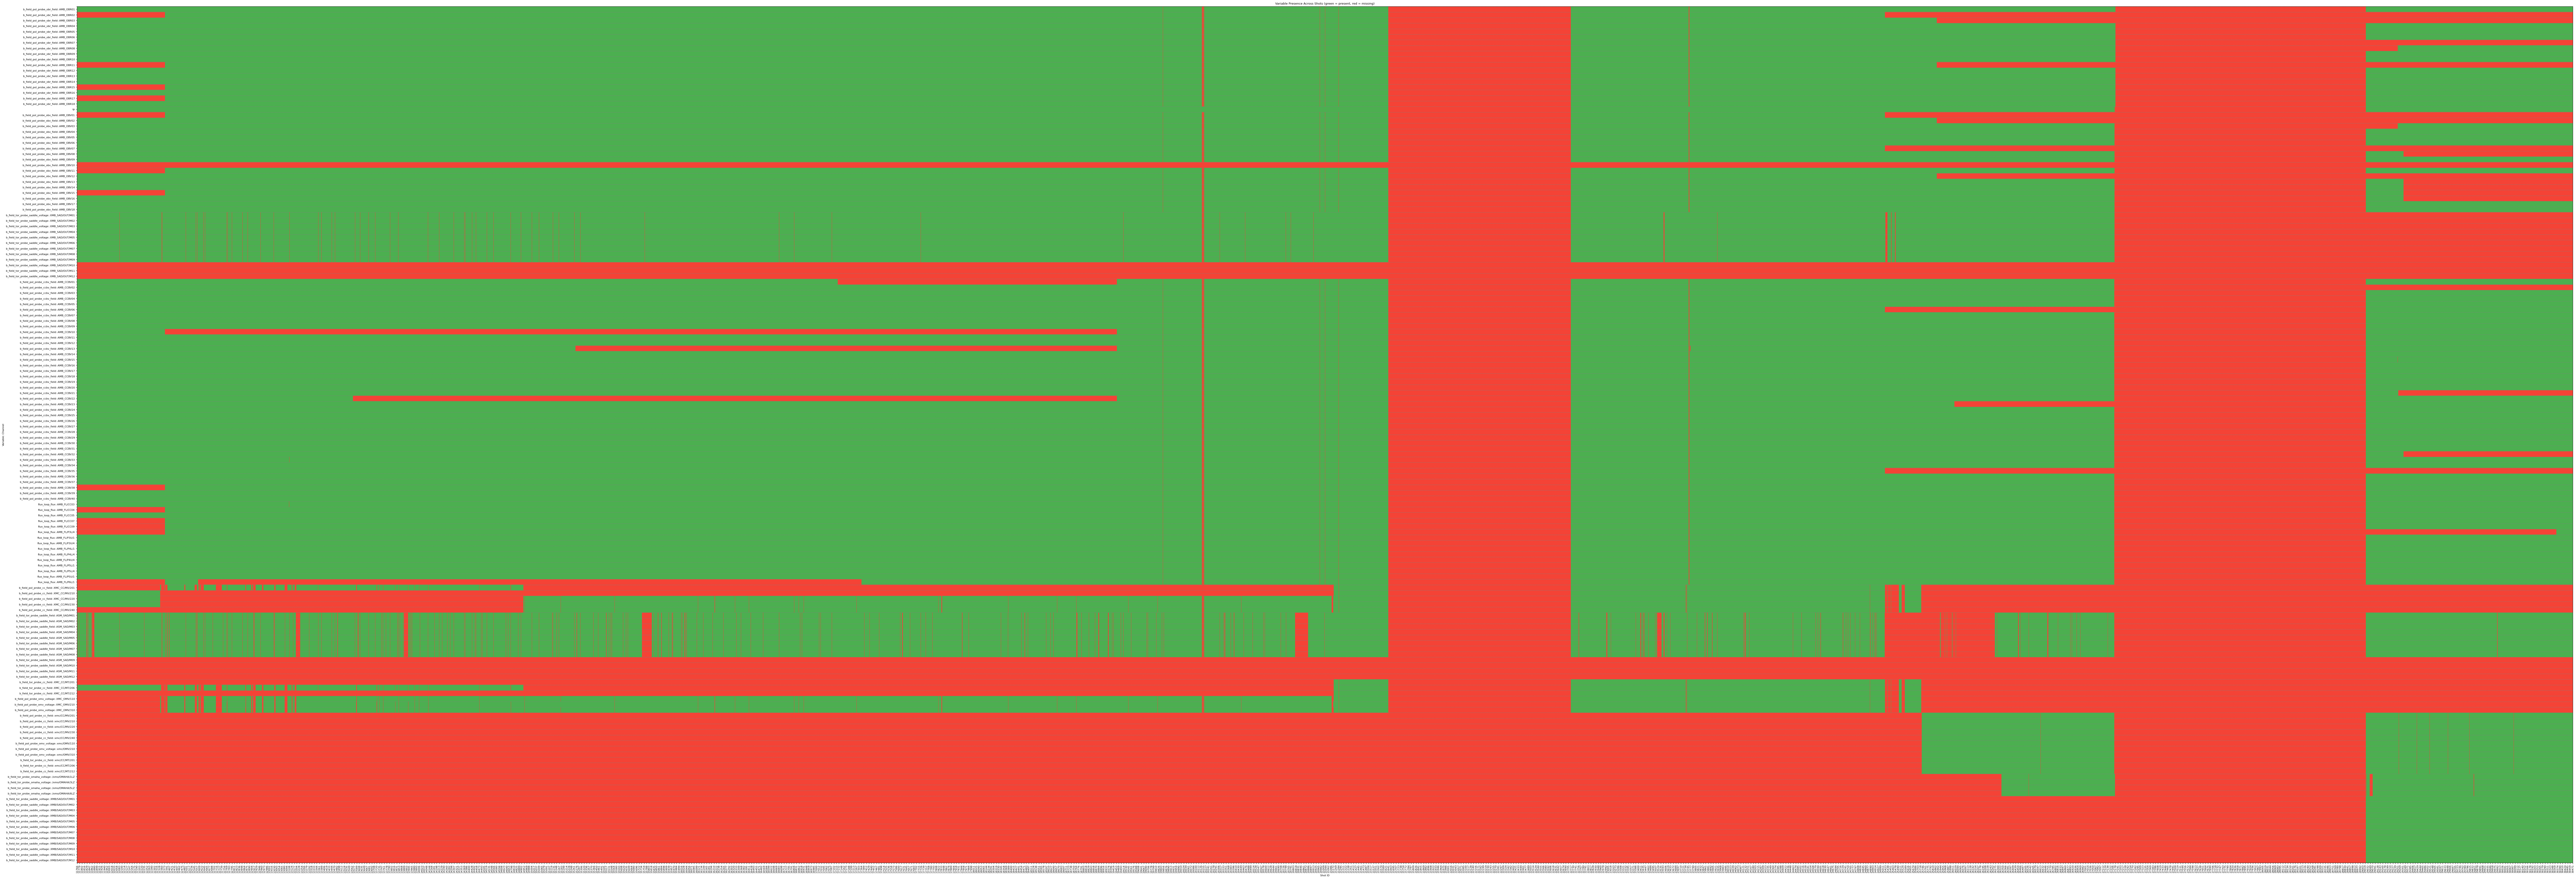

In [86]:
# Visualization of variable presence

# Create an integer matrix for colormapping: 0 = False, 1 = True
plot_df = variable_presence_all.fillna(False)
plot_matrix = plot_df.to_numpy()
int_matrix = plot_matrix.astype(int)

# Dimensions
n_vars, n_shots = int_matrix.shape

# Colors: 0 = red, 1 = green
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#f44336", "#4caf50"])  # rouge, vert

# Plot
fig, ax = plt.subplots(figsize=(n_shots * 0.01, max(16, n_vars * 0.25)))
im = ax.imshow(int_matrix, aspect='auto', cmap=cmap, interpolation='none')


ax.set_yticks(np.arange(n_vars))
ax.set_yticklabels(variable_presence_all.index)
ax.set_xticks(np.linspace(0, n_shots - 1, min(n_shots, 1000), dtype=int))
ax.set_xticklabels([variable_presence_all.columns[i] for i in np.linspace(0, n_shots - 1, min(n_shots, 1000), dtype=int)], rotation=90)
ax.set_xlabel("Shot ID")
ax.set_ylabel("Variable::Channel")
ax.set_title("Variable Presence Across Shots (green = present, red = missing)")
ax.grid(False, axis='x')
ax.set_yticks(np.arange(n_vars + 1) - 0.5, minor=True)
ax.grid(True, axis='y', which='minor', color='gray', linestyle='--')

plt.tight_layout()
plt.show()


In [66]:
data_foo = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/29007.zarr",
    group='magnetics',
)

In [67]:
data_foo["ip"].values

array([-2686.07543945, -2686.07543945, -3426.2644043 , ...,
       -5469.06787109, -5469.06787109, -5172.81787109], shape=(2944,))

### 7. What are the `cpf_*` variables ?

In [58]:
shots_df = pd.read_parquet(f'{URL}/parquet/level2/shots')

In [59]:
print(type(shots_df["cpf_p03249"]))
print("\n")
print(shots_df["cpf_p03249"])

<class 'pandas.core.series.Series'>


0        None
1        None
2        None
3        None
4        None
         ... 
11276    None
11277    None
11278    None
11279    None
11280    None
Name: cpf_p03249, Length: 11281, dtype: object


In [60]:
print(type(shots_df["cpf_p04673"]))
print("\n")
print(shots_df["cpf_p04673"])

<class 'pandas.core.series.Series'>


0        None
1        None
2        None
3        None
4        None
         ... 
11276    None
11277    None
11278    None
11279    None
11280    None
Name: cpf_p04673, Length: 11281, dtype: object


#### 8. --------